# Transfer learning and fine-tuning

In [1]:
from chapter import *

Transfer learning is a common technique for leveraging large models trained on related tasks (i.e. the **pretrained model**). Here we use ResNet {cite}`resnet` which is trained on [ImageNet](https://image-net.org/) consisting of 1M+ images in 1000 categories. To adapt the pretrained model to our task, we use only the feature extractors and retrain a **classification head**.

To avoid nullifying the pretrained weights with large random gradients, we first have to train the classification head to convergence, while keeping the weights of the pretrained model fixed. Then, we proceed with **fine-tuning** where we train the entire model with a very low learning rate, again so that the pretrained weights are gradually changed.

In [2]:
import torchinfo
from torchvision import models

resnet = models.resnet18(pretrained=True)

BATCH_SIZE = 16
torchinfo.summary(resnet, input_size=(BATCH_SIZE, 3, 49, 49))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 1000]                --
├─Conv2d: 1-1                            [16, 64, 25, 25]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 25, 25]          128
├─ReLU: 1-3                              [16, 64, 25, 25]          --
├─MaxPool2d: 1-4                         [16, 64, 13, 13]          --
├─Sequential: 1-5                        [16, 64, 13, 13]          --
│    └─BasicBlock: 2-1                   [16, 64, 13, 13]          --
│    │    └─Conv2d: 3-1                  [16, 64, 13, 13]          36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 13, 13]          128
│    │    └─ReLU: 3-3                    [16, 64, 13, 13]          --
│    │    └─Conv2d: 3-4                  [16, 64, 13, 13]          36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 13, 13]          128
│    │    └─ReLU: 3-6                    [16, 64, 13, 13]          --
│

In [3]:
in_features = resnet.fc.in_features
num_hidden = 256

head = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.BatchNorm1d(in_features),
    nn.Dropout(0.5),
    nn.Linear(in_features, num_hidden),
    nn.ReLU(),
    nn.BatchNorm1d(num_hidden),
    nn.Dropout(0.5),
    nn.Linear(num_hidden, 2),
)

model = nn.Sequential(
    nn.Sequential(*list(resnet.children())[:-2]),
    head
)

**Remark.** BatchNorm {cite}`batchnorm` on the network head aids with activation and gradient stability. Dropout is also used to regularize the dense layers.

## Static features

Freezing the feature extraction layers:

In [4]:
for param in model[0].parameters(): # model[0] = pretrained
    param.requires_grad = False

Setting up the data loaders:

In [5]:
dl_train = DataLoader(Subset(ds_train, torch.arange(32000)), batch_size=BATCH_SIZE, shuffle=True)
dl_valid = DataLoader(Subset(ds_valid, torch.arange(8000)),  batch_size=BATCH_SIZE, shuffle=False)

Training the model using AdamW {cite}`adamw` with learning rate `0.001`:

In [6]:
epochs = 10
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(dl_train), epochs=epochs)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy, scheduler=scheduler, device=DEVICE)
trainer.run(epochs=epochs, train_loader=dl_train, valid_loader=dl_valid)

  0%|          | 0/10 [00:00<?, ?it/s]

[Epoch: 01/10]    loss: 0.5991  acc: 0.7019    val_loss: 0.5274  val_acc: 0.7422
[Epoch: 02/10]    loss: 0.5862  acc: 0.6944    val_loss: 0.5135  val_acc: 0.7561
[Epoch: 03/10]    loss: 0.5926  acc: 0.6794    val_loss: 0.5142  val_acc: 0.7522
[Epoch: 04/10]    loss: 0.5714  acc: 0.6956    val_loss: 0.5250  val_acc: 0.7376
[Epoch: 05/10]    loss: 0.5760  acc: 0.7069    val_loss: 0.5082  val_acc: 0.7558
[Epoch: 06/10]    loss: 0.5508  acc: 0.7188    val_loss: 0.5039  val_acc: 0.7611
[Epoch: 07/10]    loss: 0.5172  acc: 0.7400    val_loss: 0.4862  val_acc: 0.7691
[Epoch: 08/10]    loss: 0.5345  acc: 0.7362    val_loss: 0.4896  val_acc: 0.7791
[Epoch: 09/10]    loss: 0.5257  acc: 0.7456    val_loss: 0.4851  val_acc: 0.7749
[Epoch: 10/10]    loss: 0.5327  acc: 0.7225    val_loss: 0.4857  val_acc: 0.7744


In [7]:
%%save
def plot_training_history(trainer):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    num_epochs = len(trainer.valid_log["accs"])
    num_steps_per_epoch = len(trainer.train_log["accs"]) // num_epochs
    ax[0].plot(trainer.train_log["loss"], alpha=0.3, color="C0")
    ax[1].plot(trainer.train_log["accs"], alpha=0.3, color="C0")
    ax[0].plot(trainer.train_log["loss_avg"], label="train", color="C0")
    ax[1].plot(trainer.train_log["accs_avg"], label="train", color="C0")
    ax[0].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log["loss"], label="valid", color="C1")
    ax[1].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log["accs"], label="valid", color="C1")
    ax[0].set_xlabel("step")
    ax[0].set_ylabel("loss")
    ax[0].grid(linestyle="dashed", alpha=0.3)
    ax[1].set_xlabel("step")
    ax[1].set_ylabel("accuracy")
    ax[1].grid(linestyle="dashed", alpha=0.3)
    ax[1].legend()
    ax[0].set_ylim(0, max(trainer.train_log["loss"]))
    ax[1].set_ylim(0, 1)
    ax[0].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    ax[1].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    
    fig.tight_layout();

def plot_training_history(trainer):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    num_epochs = len(trainer.valid_log["accs"])
    num_steps_per_epoch = len(trainer.train_log["accs"]) // num_epochs
    ax[0].plot(trainer.train_log["loss"], alpha=0.3, color="C0")
    ax[1].plot(trainer.train_log["accs"], alpha=0.3, color="C0")
    ax[0].plot(trainer.train_log["loss_avg"], label="train", color="C0")
    ax[1].plot(trainer.train_log["accs_avg"], label="train", color="C0")
    ax[0].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log["loss"], label="valid", color="C1")
    ax[1].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), trainer.valid_log["accs"], label="valid", color="C1")
    ax[0].set_xlabel("step")
    ax[0].set_ylabel("loss")
    ax[0].grid(linestyle="dashed", alpha=0.3)
    ax[1].set_xlabel("step")
    ax[1].set_ylabel("accuracy")
    ax[1].grid(linestyle="dashed", alpha=0.3)
    ax[1].legend()
    ax[0].set_ylim(0, max(trainer.train_log["loss"]))
    ax[1].set_ylim(0, 1)
    ax[0].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    ax[1].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
    
    fig.tight_layout();

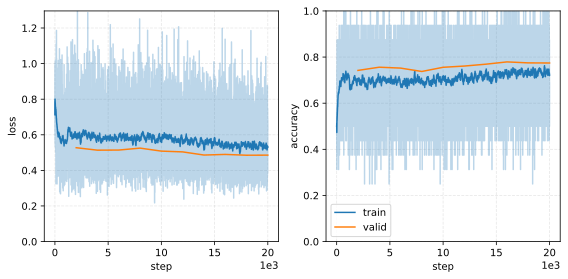

In [8]:
plot_training_history(trainer)

**Remark.** The validation step accumulates results over after an epoch for a fixed set of weights. This simulates inference performance if we load the trained model at that **checkpoint**. On the other hand, train metrics are expensive since the training dataset is large. Instead, these are accumulated at each step as an average with the previous steps.

<br>

## Fine-tuning

Unfreezing the pretrained model layers. Note that we set small learning rates:

In [9]:
for param in model[0].parameters():
    param.requires_grad = True

# 100x smaller lr (both optim and scheduler)
epochs = 20
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.05)
scheduler = OneCycleLR(optim, max_lr=0.0001, steps_per_epoch=len(dl_train), epochs=epochs)
trainer_ft = Trainer(model, optim, loss_fn=F.cross_entropy, scheduler=scheduler, device=DEVICE)
trainer_ft.run(epochs=epochs, train_loader=dl_train, valid_loader=dl_valid)

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch: 01/20]    loss: 0.4978  acc: 0.7706    val_loss: 0.4265  val_acc: 0.8160
[Epoch: 02/20]    loss: 0.4262  acc: 0.8113    val_loss: 0.3741  val_acc: 0.8434
[Epoch: 03/20]    loss: 0.4110  acc: 0.8175    val_loss: 0.3544  val_acc: 0.8540
[Epoch: 04/20]    loss: 0.3923  acc: 0.8331    val_loss: 0.3363  val_acc: 0.8626
[Epoch: 05/20]    loss: 0.3599  acc: 0.8469    val_loss: 0.3388  val_acc: 0.8596
[Epoch: 06/20]    loss: 0.3406  acc: 0.8581    val_loss: 0.3171  val_acc: 0.8699
[Epoch: 07/20]    loss: 0.3875  acc: 0.8469    val_loss: 0.3338  val_acc: 0.8685
[Epoch: 08/20]    loss: 0.3433  acc: 0.8650    val_loss: 0.3190  val_acc: 0.8856
[Epoch: 09/20]    loss: 0.3260  acc: 0.8712    val_loss: 0.3132  val_acc: 0.8698
[Epoch: 10/20]    loss: 0.3074  acc: 0.8831    val_loss: 0.2931  val_acc: 0.8825
[Epoch: 11/20]    loss: 0.3176  acc: 0.8806    val_loss: 0.2966  val_acc: 0.8868
[Epoch: 12/20]    loss: 0.3048  acc: 0.8775    val_loss: 0.2904  val_acc: 0.8848
[Epoch: 13/20]    loss: 0.26

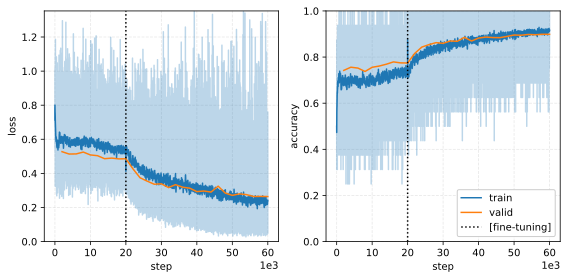

In [10]:
loss = trainer.train_log["loss"] + trainer_ft.train_log["loss"]
accs = trainer.train_log["accs"] + trainer_ft.train_log["accs"]
loss_avg = trainer.train_log["loss_avg"] + trainer_ft.train_log["loss_avg"]
accs_avg = trainer.train_log["accs_avg"] + trainer_ft.train_log["accs_avg"]
val_loss = trainer.valid_log["loss"] + trainer_ft.valid_log["loss"]
val_accs = trainer.valid_log["accs"] + trainer_ft.valid_log["accs"]
num_epochs = len(val_loss)
num_steps_per_epoch = len(loss) // num_epochs

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(loss, alpha=0.3, color="C0")
ax[1].plot(accs, alpha=0.3, color="C0")
ax[0].plot(loss_avg, label="train", color="C0")
ax[1].plot(accs_avg, label="train", color="C0")
ax[0].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), val_loss, label="valid", color="C1")
ax[1].plot(list(range(num_steps_per_epoch, (num_epochs + 1) * num_steps_per_epoch, num_steps_per_epoch)), val_accs, label="valid", color="C1")
ax[0].axvline(len(trainer.train_log["loss"]), color="black", linestyle="dotted", label="[fine-tuning]")
ax[1].axvline(len(trainer.train_log["loss"]), color="black", linestyle="dotted", label="[fine-tuning]")
ax[0].set_xlabel("step")
ax[0].set_ylabel("loss")
ax[0].grid(linestyle="dashed", alpha=0.3)
ax[0].set_ylim(0, max(loss))
ax[1].set_xlabel("step")
ax[1].set_ylabel("accuracy")
ax[1].grid(linestyle="dashed", alpha=0.3)
ax[1].set_ylim(0, 1)
ax[1].legend(framealpha=1.0)
ax[0].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
ax[1].ticklabel_format(axis="x", style="sci", scilimits=(3, 3))
fig.tight_layout();

Fig. *The weights of the classification head are trained on the outputs of the pretrained ResNet model with fixed weights. After the classification head forms proper weights, the pretrained weights are unfreezed, and trained with small LR. Performance improves at a faster rate, but also fluctuates more at this stage.*

<br>

**Remarks.** The model overfits and the validation curves diverge very early in the training when we turn off data augmentation (i.e. model memorizes the training data). Data augmentation prevents this by adding noise in the input. The dense layers also does not train well without BN. Finally, since the data is slightly imbalanced, we should also look at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and [PR curve](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html).

## Inference

Note that calling the model on an input `x` with large batch dim may cause memory error for large models. Hence, using a data loader for offline batch inference is good practice:

In [11]:
class InputDataLoader(DataLoader):
    def __init__(self, data_loader):
        self.data_loader = data_loader

    def __iter__(self):
        for batch in self.data_loader:
            yield batch[0]


@torch.inference_mode()
def batch_predict(trainer: Trainer, input_loader: DataLoader):
    with eval_context(trainer.model):
        preds = [trainer(x) for x in input_loader]
        preds = torch.cat(preds, dim=0)
    return preds


pred = batch_predict(trainer, InputDataLoader(dl_valid))
print(pred.shape)
print(pred)

torch.Size([8000, 2])
tensor([[ 0.0836, -0.0971],
        [ 1.1856, -1.1767],
        [ 0.8685, -0.8674],
        ...,
        [ 1.0003, -0.9968],
        [-2.4745,  2.4580],
        [-2.5150,  2.4989]], device='mps:0')


This should be equal to the final validation accuracy:

In [12]:
y = torch.cat([batch[1] for batch in dl_valid], dim=0)
print((pred.argmax(dim=1) == y.to(DEVICE)).float().mean().item())
print(trainer_ft.evaluate(dl_valid)["accs"])
print(trainer_ft.valid_log["accs"][-1]) # or look at final valid log

0.8986250162124634
0.898625
0.898625


Note that input from our data loaders come transformed. For processing raw images, we have to transform the inputs in eval mode:

In [13]:
file_path = "data/histopathologic-cancer-detection/test/0a0a1f3867f41e02353afcaf503f63be1bdd35ec.tif"
test_data = cv2.imread(file_path)
print(trainer.predict(transform_infer(test_data).unsqueeze(0)))

tensor([[ 1.4946, -1.4783]], device='mps:0')


In [14]:
PATH = "./artifacts/cancer_detection_model.pkl"
torch.save(trainer.model.state_dict(), PATH)